# Imports

In [ ]:
# Install the necessary Python packages
!pip install numpy
!pip install tqdm
!pip install torch
!pip install torchvision
!pip install matplotlib
!pip install Pillow

In [307]:
# prerequisites
import torch
import torch.utils.data
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F
from torch import optim

import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable
from collections import deque
from sklearn.manifold import TSNE

# Download Dataset

In [4]:
bs = 100
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

# Section 1: Autoencoder

In [402]:
class Autoencoder(nn.Module):

  def __init__(
      self,
      input_dim: int = 784,
      hidden_dim: int = 256,
      latent_dim: int = 6,
      device: str = "cuda"
  ):
    super(Autoencoder, self).__init__()
    self.device = device
    self.latent = None
    self.latent_dim = latent_dim
    self.hidden_dim = hidden_dim

    ######### Your code starts here #########
    # Encoder architecture:
    # 2 fully connected layers with ReLU activations
    self.encoder = nn.Sequential(
        nn.Linear(input_dim, hidden_dim),
        nn.ReLU(inplace=True),
        nn.Linear(hidden_dim, latent_dim),
        nn.ReLU(inplace=True)
    )

    # Decoder architecture:
    # 3 fully connected layers with ReLU activations
    self.decoder = nn.Sequential(
        nn.Linear(latent_dim, hidden_dim),
        nn.ReLU(inplace=True),
        nn.Linear(hidden_dim, hidden_dim),
        nn.ReLU(inplace=True),
        nn.Linear(hidden_dim, input_dim),
        nn.Sigmoid() # to get pixel values between 0 and 1
    )

    # Choose the correct final layer output activation

    ######### Your code ends here #########

  def forward(self, x):
    B = x.shape[0]
    x = x.reshape(B, -1)
    latent = self.encoder(x)
    reconstruction = self.decoder(latent)
    reconstruction = reconstruction.reshape(B, 1, 28, 28)

    self.latent = latent
    return reconstruction



# create buffer class for storing latent representations and labels
# torch.Size([100, 1, 28, 28]) torch.Size([100])
# torch.float32 torch.int64
class Buffer:
  def __init__(self, size: int = 1000):
    self.size = size
    self.latents = deque(maxlen=size)
    self.labels = deque(maxlen=size)
    # self.labelcounts = np.zeros(10)
  
  def add(self, latent: torch.Tensor, label: torch.Tensor):
    self.latents.append(latent)
    self.labels.append(label)
    # self.labelcounts[label] += 1
  
  def add_batch(self, latents: torch.Tensor, labels: torch.Tensor):
    for i in range(latents.shape[0]):
      self.add(latents[i], labels[i])

  def sample(self, label=None):
    if label is None:
      idx = np.random.randint(self.size)
    else:
      idx = np.random.choice(np.where(np.array(self.labels) == label)[0])
    return self.latents[idx], self.labels[idx]
  
  def get_latents_and_labels(self):
    latents_tensor = torch.stack([latent for latent in self.latents])
    labels_tensor = torch.stack([label for label in self.labels])
    return latents_tensor, labels_tensor


# Section 2: Variational Autoencoder

In [403]:
class Split(torch.nn.Module):
    def __init__(self, *modules: torch.nn.Module):
        super().__init__()
        self.modules = modules

    def forward(self, inputs):
        return [module(inputs) for module in self.modules]

class VAE(nn.Module):

  def __init__(self, input_dim: int = 784, hidden_dim: int = 256, latent_dim: int = 2, device: str = "cuda"):
    super(VAE, self).__init__()
    self.latent = None
    self.latent_dim = latent_dim
    self.hidden_dim = hidden_dim
    self.device = device

    ######### Your code starts here #########
    # Encoder architecture:
    # 2 fully connected layers with ReLU activations

    # Decoder architecture:
    # 3 fully connected layers with ReLU activations

    # Separate linear layers to predict the latent mean and logvar

    # Choose the correct final layer output activation

    self.encoder = nn.Sequential(
        nn.Flatten(),
        nn.Linear(input_dim, hidden_dim),
        nn.ReLU(inplace=True),
        Split(
            nn.Linear(hidden_dim, latent_dim), # mean layer
            nn.Linear(hidden_dim, latent_dim), # logvar layer
        )
    )

    self.decoder = nn.Sequential(
        nn.Linear(latent_dim, hidden_dim),
        nn.ReLU(inplace=True),
        nn.Linear(hidden_dim, hidden_dim),
        nn.ReLU(inplace=True),
        nn.Linear(hidden_dim, input_dim),
        nn.Sigmoid(), # to get pixel values between 0 and 1
        nn.Unflatten(1, (1, 28, 28))
    )

    ######### Your code ends here #########

  def reparameterize(self, mu, log_var):
    std = torch.exp(0.5 * log_var)
    eps = torch.randn_like(std)
    return mu + std * eps

  def sample(self, n):
    sample = torch.randn(n, self.latent_dim).to(self.device)
    return self.decoder(sample)

  def forward(self, x):
    mu, log_var = self.encoder(x) # logvar instead of variance for numerical stability
    z = self.reparameterize(mu, log_var)
    reconstruction = self.decoder(z)
    self.latent = z
    return reconstruction, mu, log_var

# Training Loop

In [398]:
def _get_recon_and_loss(model_cls, model, loss_fn, data, class_label=None, eval=False):
  if model_cls == "ae":
    recon_batch = model(data)
    loss = loss_fn(recon_batch, data)

  elif model_cls == "vae":
    recon_batch, mu, log_var = model(data)
    loss = loss_fn(recon_batch, data, mu, log_var)

  elif model_cls == "cvae":
    recon_batch, mu, log_var = model(data, class_label)
    loss = loss_fn(recon_batch, data, mu, log_var)

  else:
    raise NotImplementedError
  
  return recon_batch, loss
    

def test_single_epoch(
    model_cls: str,
    model: nn.Module,
    loss_fn: Callable,
    data_loader: DataLoader,
    epoch: int,
    buffer: Buffer = None
):
  model.eval()
  test_loss = 0
  for batch_idx, (data, class_label) in enumerate(data_loader):
    data = data.to(device)
    class_label = class_label.to(device)

    recon_batch, loss = _get_recon_and_loss(model_cls, model, loss_fn, data, class_label)
    test_loss += loss.item()
    buffer.add_batch(model.latent, class_label)


  avg_test_loss = test_loss / len(data_loader.dataset)
  print('====> Epoch: {} Average test loss: {:.6f}'.format(epoch, avg_test_loss))
  return avg_test_loss
  

def train_single_epoch(
    model_cls: str,
    model: nn.Module,
    loss_fn: Callable,
    data_loader: DataLoader,
    optimizer,
    epoch: int
):
  # set model to training mode
  model.train()
  train_loss = 0
  for batch_idx, (data, class_label) in enumerate(data_loader):
    data = data.to(device)
    class_label = class_label.to(device)

    optimizer.zero_grad()
    recon_batch, loss = _get_recon_and_loss(model_cls, model, loss_fn, data, class_label)
    loss.backward()

    train_loss += loss.item()
    optimizer.step()

    # if batch_idx % log_interval == 0:
    #   print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
    #         epoch, batch_idx * len(data), len(data_loader.dataset),
    #         100. * batch_idx / len(data_loader), loss.item() / len(data)))

  avg_loss = train_loss / len(data_loader.dataset)
  print('====> Epoch: {} Average loss: {:.6f}'.format(epoch, avg_loss))
  
  # Plot reconstructions
  n = min(num_examples, 8)
  imgs = data[:n]
  reconstructed_imgs = recon_batch.view(batch_size,-1, 28, 28)[:n]

  comparisons = torch.cat([imgs, reconstructed_imgs])

  # sample some from the latent space, with class label 0
  if model_cls in ["vae", "cvae"]:
    latent_samples = model.sample(n=n)
    latent_samples = latent_samples.view(n, -1, 28, 28)
    comparisons = torch.cat([comparisons, latent_samples])

  comparisons = torchvision.utils.make_grid(comparisons)
  comparisons = comparisons.detach().cpu().numpy()

  print("Reconstructions: ")
  plt.imshow(comparisons.transpose(1,2,0))
  plt.axis('off')
  plt.show()


  return avg_loss


# Section 3: Train Autoencoder


====== Training Autoencoder with hidden dimension 32 ======
====> Epoch: 0 Average loss: 0.002678
Reconstructions: 


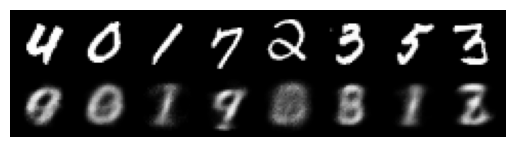

====> Epoch: 0 Average test loss: 0.002181
====> Epoch: 1 Average loss: 0.002120
Reconstructions: 


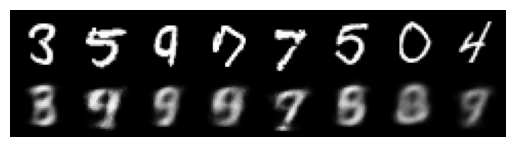

====> Epoch: 1 Average test loss: 0.002001
====> Epoch: 2 Average loss: 0.001949
Reconstructions: 


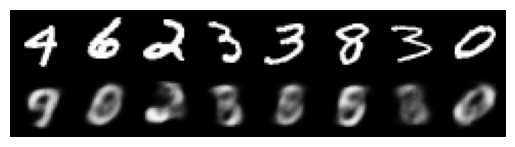

====> Epoch: 2 Average test loss: 0.001898
====> Epoch: 3 Average loss: 0.001898
Reconstructions: 


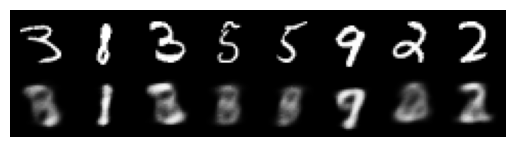

====> Epoch: 3 Average test loss: 0.001870
====> Epoch: 4 Average loss: 0.001875
Reconstructions: 


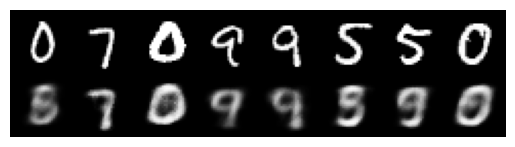

====> Epoch: 4 Average test loss: 0.001851
====> Epoch: 5 Average loss: 0.001851
Reconstructions: 


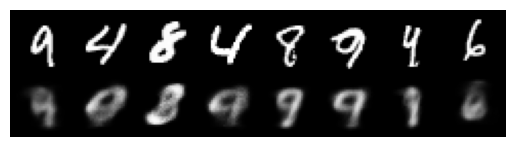

====> Epoch: 5 Average test loss: 0.001825
====> Epoch: 6 Average loss: 0.001811
Reconstructions: 


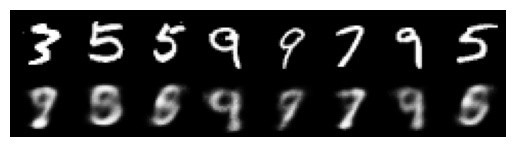

====> Epoch: 6 Average test loss: 0.001752
====> Epoch: 7 Average loss: 0.001746
Reconstructions: 


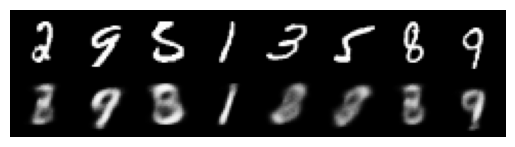

====> Epoch: 7 Average test loss: 0.001719
====> Epoch: 8 Average loss: 0.001721
Reconstructions: 


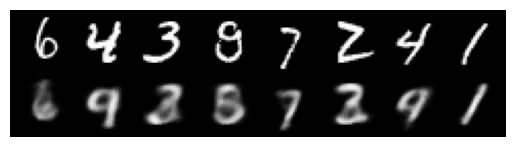

====> Epoch: 8 Average test loss: 0.001699
====> Epoch: 9 Average loss: 0.001702
Reconstructions: 


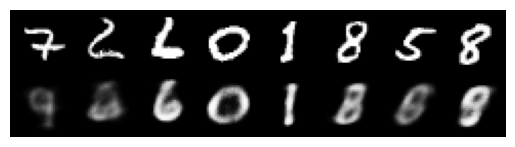

====> Epoch: 9 Average test loss: 0.001683

====== Training Autoencoder with hidden dimension 128 ======
====> Epoch: 0 Average loss: 0.002315
Reconstructions: 


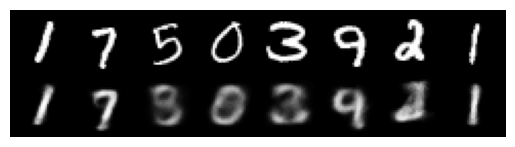

====> Epoch: 0 Average test loss: 0.001851
====> Epoch: 1 Average loss: 0.001783
Reconstructions: 


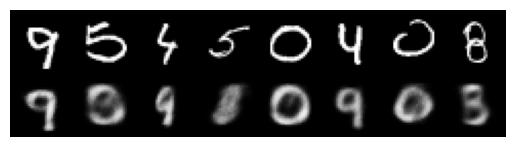

====> Epoch: 1 Average test loss: 0.001693
====> Epoch: 2 Average loss: 0.001642
Reconstructions: 


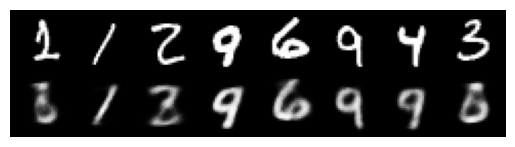

====> Epoch: 2 Average test loss: 0.001593
====> Epoch: 3 Average loss: 0.001573
Reconstructions: 


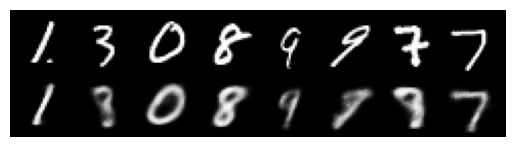

====> Epoch: 3 Average test loss: 0.001542
====> Epoch: 4 Average loss: 0.001538
Reconstructions: 


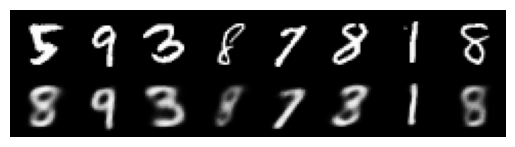

====> Epoch: 4 Average test loss: 0.001519
====> Epoch: 5 Average loss: 0.001518
Reconstructions: 


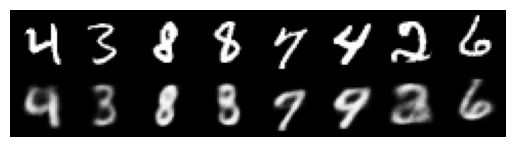

====> Epoch: 5 Average test loss: 0.001504
====> Epoch: 6 Average loss: 0.001502
Reconstructions: 


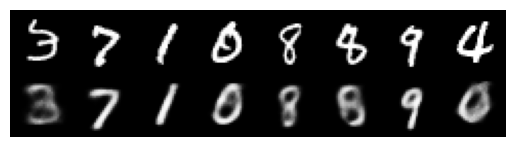

====> Epoch: 6 Average test loss: 0.001491
====> Epoch: 7 Average loss: 0.001489
Reconstructions: 


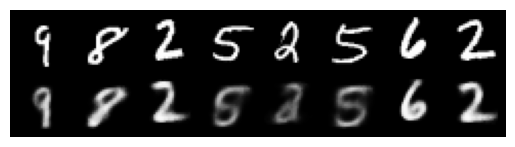

====> Epoch: 7 Average test loss: 0.001480
====> Epoch: 8 Average loss: 0.001478
Reconstructions: 


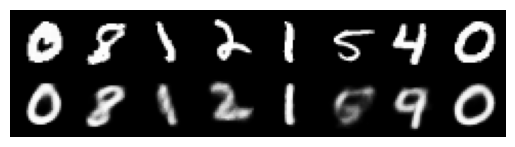

====> Epoch: 8 Average test loss: 0.001471
====> Epoch: 9 Average loss: 0.001470
Reconstructions: 


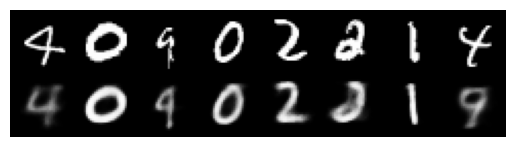

====> Epoch: 9 Average test loss: 0.001464

====== Training Autoencoder with hidden dimension 512 ======
====> Epoch: 0 Average loss: 0.002230
Reconstructions: 


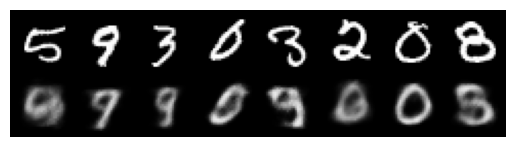

====> Epoch: 0 Average test loss: 0.001890
====> Epoch: 1 Average loss: 0.001791
Reconstructions: 


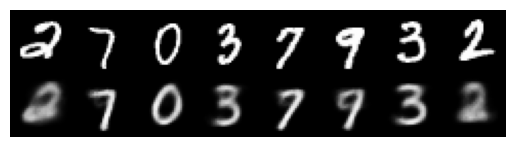

====> Epoch: 1 Average test loss: 0.001733
====> Epoch: 2 Average loss: 0.001710
Reconstructions: 


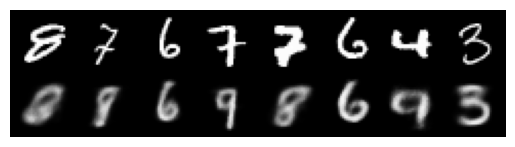

====> Epoch: 2 Average test loss: 0.001689
====> Epoch: 3 Average loss: 0.001673
Reconstructions: 


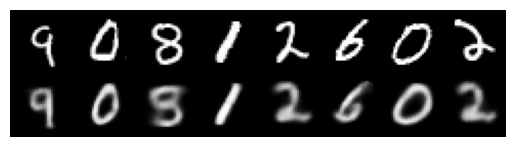

====> Epoch: 3 Average test loss: 0.001664
====> Epoch: 4 Average loss: 0.001648
Reconstructions: 


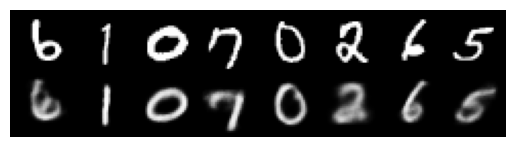

====> Epoch: 4 Average test loss: 0.001645
====> Epoch: 5 Average loss: 0.001595
Reconstructions: 


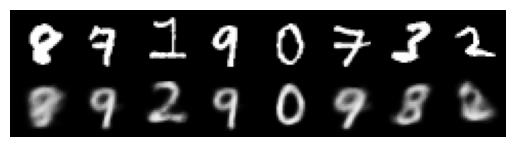

====> Epoch: 5 Average test loss: 0.001550
====> Epoch: 6 Average loss: 0.001532
Reconstructions: 


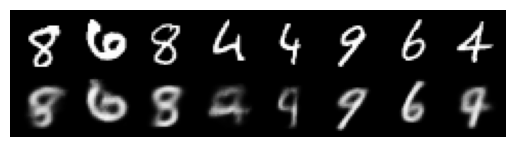

====> Epoch: 6 Average test loss: 0.001525
====> Epoch: 7 Average loss: 0.001508
Reconstructions: 


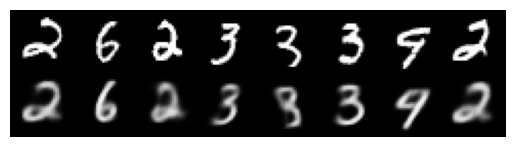

====> Epoch: 7 Average test loss: 0.001508
====> Epoch: 8 Average loss: 0.001491
Reconstructions: 


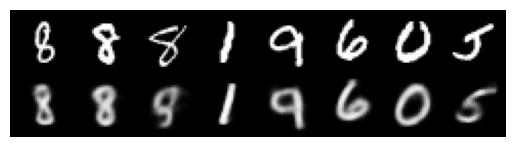

====> Epoch: 8 Average test loss: 0.001496
====> Epoch: 9 Average loss: 0.001478
Reconstructions: 


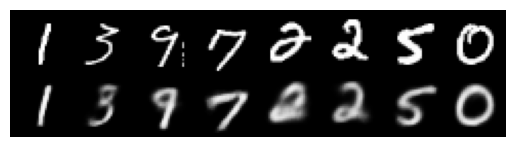

====> Epoch: 9 Average test loss: 0.001488


In [459]:
# Define training variables, feel free to modify these for the problem
log_interval = 100
num_epochs = 10
image, cls = train_dataset[0]
input_dim = np.product(image.shape)
batch_size = 100
num_examples = len(train_dataset)
device = "cuda" if torch.cuda.is_available() else "cpu"


latent_dim = 6
hidden_dims = [32, 128, 512]

all_losses = {
  f"ae{dim}": {"train_losses": [], "test_losses": []} 
  for dim in hidden_dims}
models = {}
buffers = {}

# debug = True
debug = False
if debug:
  hidden_dims = [512]
  num_epochs = 2

for hidden_dim in hidden_dims:
  # build model and buffer
  ae = Autoencoder(
    input_dim=input_dim,
    hidden_dim=hidden_dim,
    latent_dim=latent_dim,
    device=device
  )
  buffer = Buffer(size=5000)


  # put model on device
  if torch.cuda.is_available():
    ae.cuda()

  # device optimizer
  optimizer = optim.Adam(ae.parameters())

  ######### Your code starts here #########
  # Define the loss function for a vanilla Autoencoder.
  loss_fn = nn.BCELoss()
  ######### Your code ends here #########

  # train
  print(f"\n====== Training Autoencoder with hidden dimension {hidden_dim} ======")
  for epoch in range(0, num_epochs):
    avg_train_loss_epoch = train_single_epoch(
      model_cls="ae",
      model=ae,
      loss_fn=loss_fn,
      data_loader=train_loader,
      optimizer=optimizer,
      epoch=epoch
    )

    avg_test_loss_epoch = test_single_epoch(
      model_cls="ae",
      model=ae,
      loss_fn=loss_fn,
      data_loader=test_loader,
      epoch=epoch,
      buffer=buffer
    )

    all_losses[f"ae{hidden_dim}"]["train_losses"].append(avg_train_loss_epoch)
    all_losses[f"ae{hidden_dim}"]["test_losses"].append(avg_test_loss_epoch)
  models[f"ae{hidden_dim}"] = ae
  buffers[f"ae{hidden_dim}"] = buffer

# Visualization

In [453]:
def viz_samples_ae(model, buffer, model_key, title):
    """
    first row is embeddings taken directly from testing set, second and row third are embeddings sampled from the latent space. 
    sampling is done by adding Gaussian perturbations
    """
    NUM_DIGITS = 10
    embeddings_test = [buffer.sample(label=i)[0] for i in range(NUM_DIGITS)]
    comparisons = torch.stack([embeddings_test[i] for i in range(NUM_DIGITS)])
    comparisons = torch.concat([
        comparisons,
        comparisons + torch.randn_like(comparisons) * 2,
        comparisons + torch.randn_like(comparisons) * 4
        ],
    )

    comparisons = model.decoder(comparisons).view(NUM_DIGITS * 3,1,28,28)
    comparisons = torchvision.utils.make_grid(comparisons, nrow=10)
    comparisons = comparisons.detach().cpu().numpy()

    plt.imshow(comparisons.transpose(1,2,0))
    plt.axis('off')
    plt.title(title)
    plt.savefig(f"output/p3/{model_key}_samples.png")

def viz_samples_vae(model, model_key, title):
    comparisons = model.sample(25)
    comparisons = torchvision.utils.make_grid(comparisons, nrow=10)
    comparisons = comparisons.detach().cpu().numpy()

    plt.imshow(comparisons.transpose(1,2,0))
    plt.axis('off')
    plt.title(title)
    plt.savefig(f"output/p3/{model_key}_samples.png")

def viz_samples_cvae(model, model_key, title):
    comparisons = torch.cat([model.sample(1, class_label=i) for _ in range(3) for i in range(10)])
    comparisons = torchvision.utils.make_grid(comparisons, nrow=10)
    comparisons = comparisons.detach().cpu().numpy()

    plt.imshow(comparisons.transpose(1,2,0))
    plt.axis('off')
    plt.title(title)
    plt.savefig(f"output/p3/{model_key}_samples.png")

def viz_tsne(buffer, model_key, title):
    latents, labels = buffer.get_latents_and_labels()
    latents = latents.detach().cpu().numpy()
    labels = labels.detach().cpu().numpy()

    out = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=5).fit_transform(latents)

    plt.figure()
    plt.scatter(out[:,0], out[:,1], s=5, c=labels, cmap='tab10')
    plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
    plt.title(title)
    plt.savefig(f"output/p3/{model_key}_tsne.png")


def plot_losses(all_losses: dict, model_cls: str, hidden_dims: list, title: str, fout: str):
    """
    Expects a dictionary of the form:
    all_losses = {
        dim (str): {
            "train_losses": [],
            "test_losses": []
        }
    }
    """
    plt.figure()
    fig, _ = plt.subplots(1, 3, sharey=True, sharex=True, figsize=(8,6))
    for dim, ax in zip(hidden_dims, plt.gcf().axes):
        ax.plot(all_losses[f"{model_cls}{dim}"]["train_losses"], label="Train loss", color="blue")
        ax.plot(all_losses[f"{model_cls}{dim}"]["test_losses"], label="Test loss", color="red")
        ax.set_title(f"Hidden dim: {dim}")
    plt.suptitle(title)
    plt.legend()

    plt.gcf().text(0.5, 0.04, 'Epoch', ha='center', va='center')
    plt.gcf().text(0.06, 0.5, 'Loss', ha='center', va='center', rotation='vertical')
    fig.tight_layout(rect=[0.05, 0.05, 1, 1])
    plt.savefig(f"output/p3/{fout}.png")



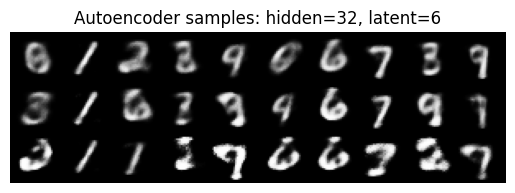

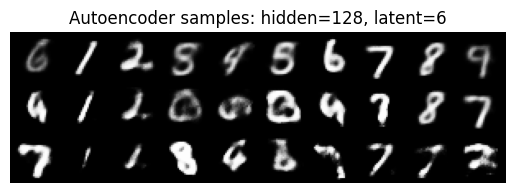

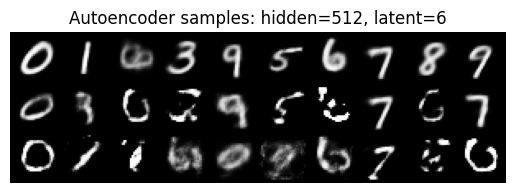

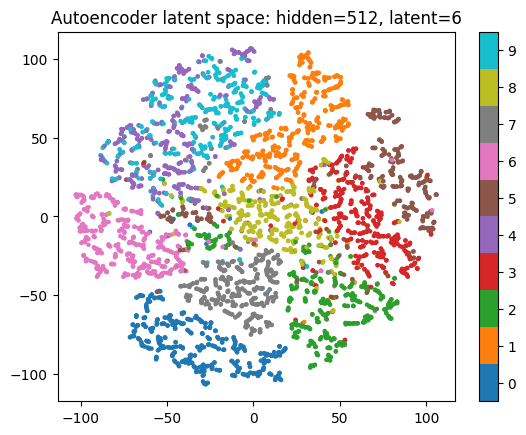

<Figure size 640x480 with 0 Axes>

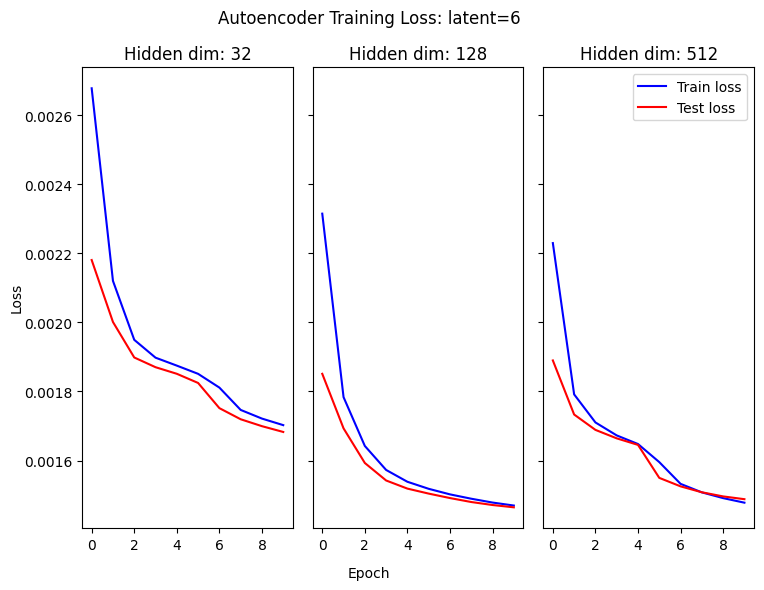

In [460]:
for model_key in ["ae32", "ae128", "ae512"]:
  model = models[model_key]
  buffer = buffers[model_key]

  plt.clf()

  title = f"Autoencoder samples: hidden={model.hidden_dim}, latent={model.latent_dim}"
  viz_samples_ae(model, buffer, model_key, title)

  title = f"Autoencoder latent space: hidden={model.hidden_dim}, latent={model.latent_dim}"
  viz_tsne(buffer, model_key, title)

plot_losses(all_losses, "ae", hidden_dims, f"Autoencoder Training Loss: latent={model.latent_dim}", "ae_losses")

# Section 4: Train Variational Autoencoder

====> Epoch: 0 Average loss: 224.928768
Reconstructions: 


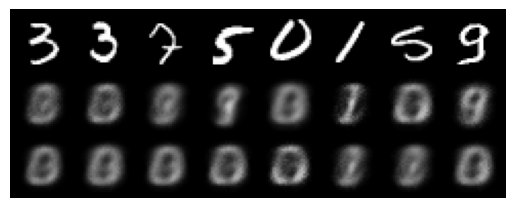

====> Epoch: 0 Average test loss: 195.298096
====> Epoch: 1 Average loss: 191.001991
Reconstructions: 


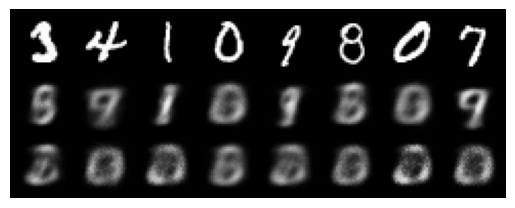

====> Epoch: 1 Average test loss: 186.531859
====> Epoch: 2 Average loss: 183.179800
Reconstructions: 


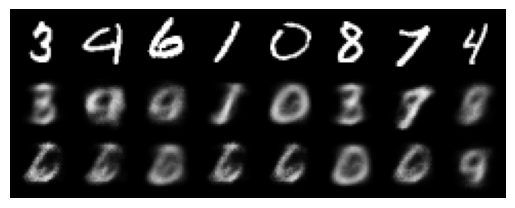

====> Epoch: 2 Average test loss: 176.911865
====> Epoch: 3 Average loss: 173.991075
Reconstructions: 


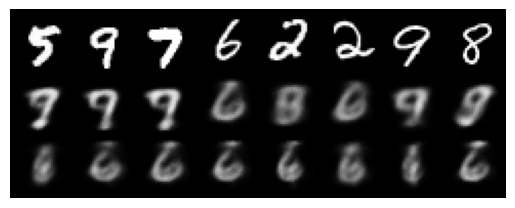

====> Epoch: 3 Average test loss: 171.119986
====> Epoch: 4 Average loss: 170.378023
Reconstructions: 


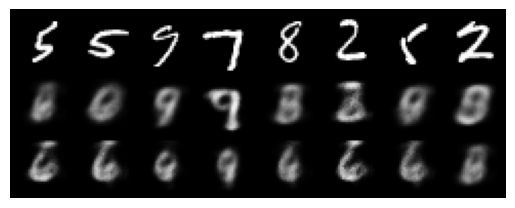

====> Epoch: 4 Average test loss: 168.618188
====> Epoch: 5 Average loss: 168.260308
Reconstructions: 


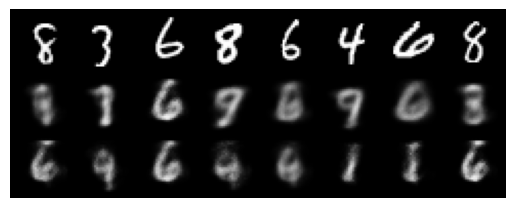

====> Epoch: 5 Average test loss: 166.570185
====> Epoch: 6 Average loss: 166.528224
Reconstructions: 


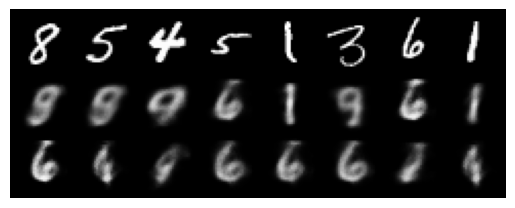

====> Epoch: 6 Average test loss: 165.063828
====> Epoch: 7 Average loss: 165.235343
Reconstructions: 


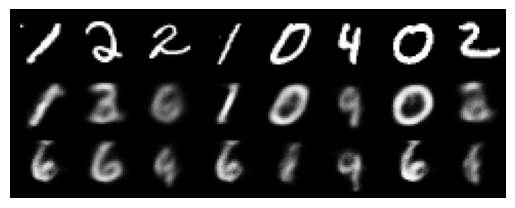

====> Epoch: 7 Average test loss: 164.064775
====> Epoch: 8 Average loss: 164.355368
Reconstructions: 


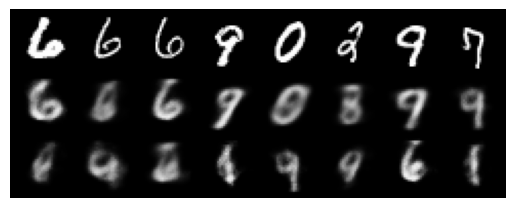

====> Epoch: 8 Average test loss: 163.254388
====> Epoch: 9 Average loss: 163.632544
Reconstructions: 


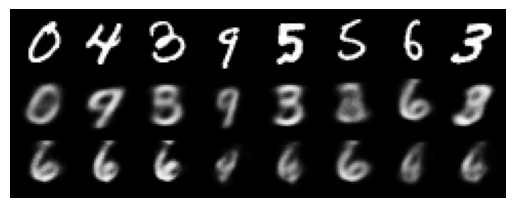

====> Epoch: 9 Average test loss: 162.642482
====> Epoch: 0 Average loss: 199.482365
Reconstructions: 


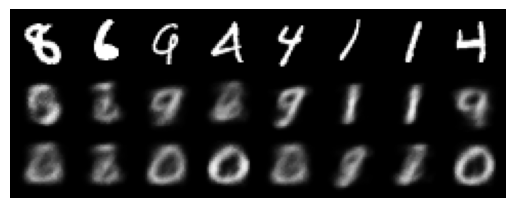

====> Epoch: 0 Average test loss: 170.072184
====> Epoch: 1 Average loss: 162.693160
Reconstructions: 


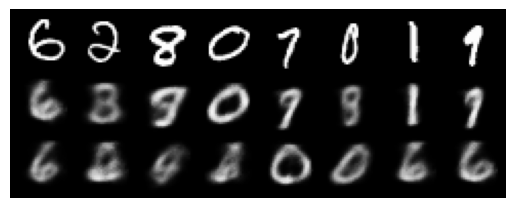

====> Epoch: 1 Average test loss: 157.566902
====> Epoch: 2 Average loss: 155.765175
Reconstructions: 


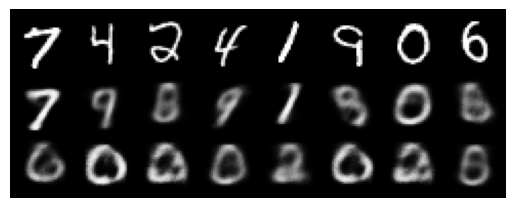

====> Epoch: 2 Average test loss: 153.214559
====> Epoch: 3 Average loss: 152.528241
Reconstructions: 


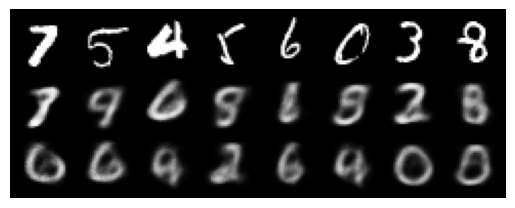

====> Epoch: 3 Average test loss: 150.870524
====> Epoch: 4 Average loss: 150.493271
Reconstructions: 


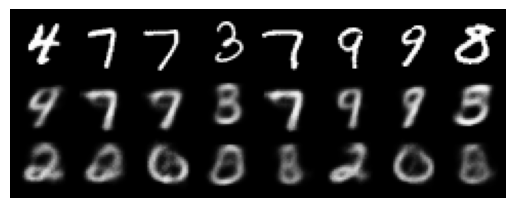

====> Epoch: 4 Average test loss: 149.369979
====> Epoch: 5 Average loss: 149.184569
Reconstructions: 


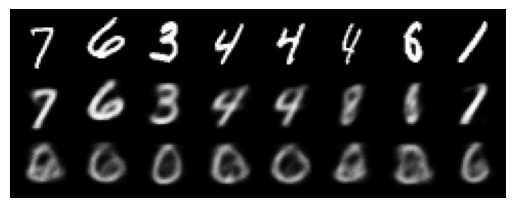

====> Epoch: 5 Average test loss: 148.040541
====> Epoch: 6 Average loss: 148.088456
Reconstructions: 


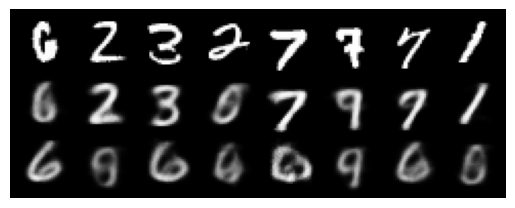

====> Epoch: 6 Average test loss: 147.384769
====> Epoch: 7 Average loss: 147.344107
Reconstructions: 


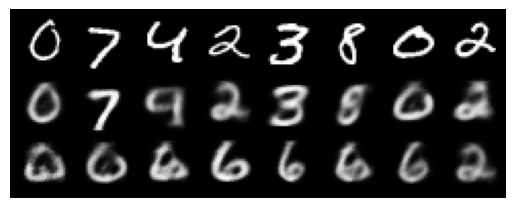

====> Epoch: 7 Average test loss: 146.628124
====> Epoch: 8 Average loss: 146.626825
Reconstructions: 


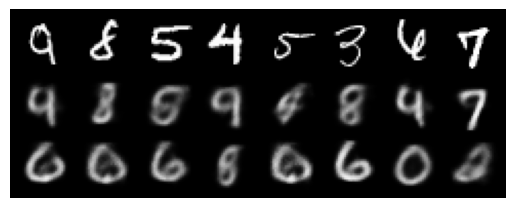

====> Epoch: 8 Average test loss: 146.069371
====> Epoch: 9 Average loss: 146.151402
Reconstructions: 


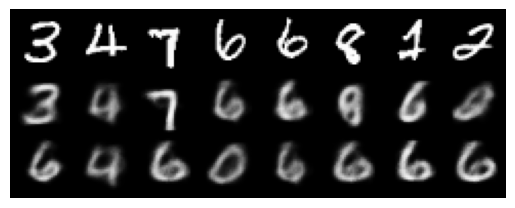

====> Epoch: 9 Average test loss: 145.341262
====> Epoch: 0 Average loss: 165.929931
Reconstructions: 


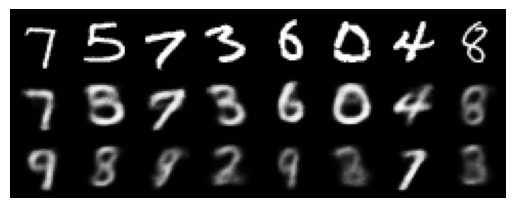

====> Epoch: 0 Average test loss: 138.086756
====> Epoch: 1 Average loss: 132.912925
Reconstructions: 


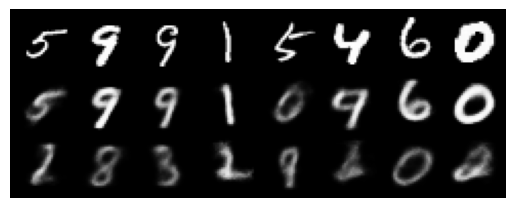

====> Epoch: 1 Average test loss: 127.854407
====> Epoch: 2 Average loss: 126.314494
Reconstructions: 


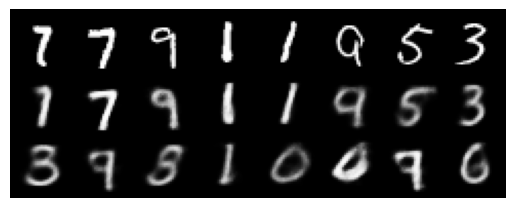

====> Epoch: 2 Average test loss: 123.928300
====> Epoch: 3 Average loss: 123.114299
Reconstructions: 


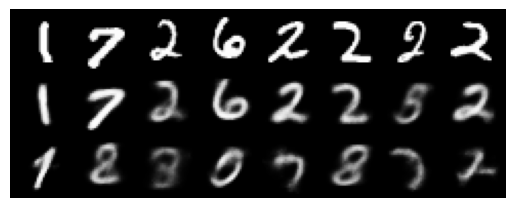

====> Epoch: 3 Average test loss: 121.964635
====> Epoch: 4 Average loss: 121.153806
Reconstructions: 


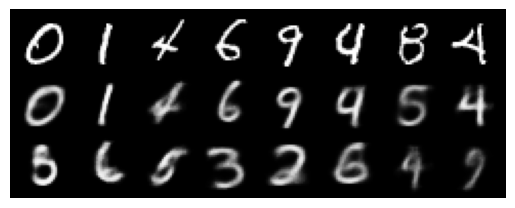

====> Epoch: 4 Average test loss: 120.068375
====> Epoch: 5 Average loss: 119.836146
Reconstructions: 


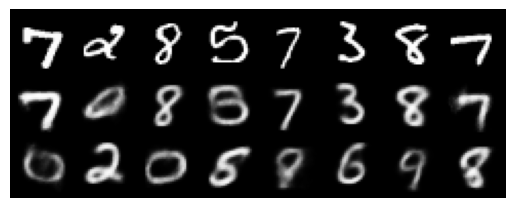

====> Epoch: 5 Average test loss: 119.332024
====> Epoch: 6 Average loss: 118.775912
Reconstructions: 


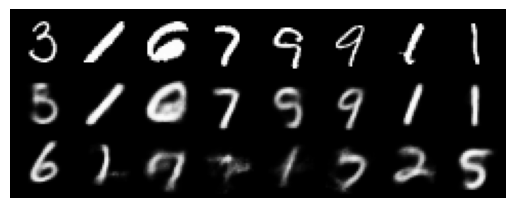

====> Epoch: 6 Average test loss: 118.631395
====> Epoch: 7 Average loss: 117.928404
Reconstructions: 


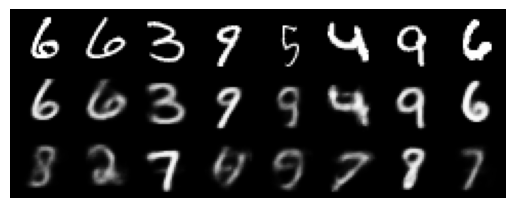

====> Epoch: 7 Average test loss: 117.704939
====> Epoch: 8 Average loss: 117.256274
Reconstructions: 


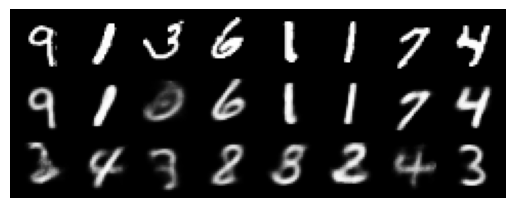

====> Epoch: 8 Average test loss: 117.704123
====> Epoch: 9 Average loss: 116.626250
Reconstructions: 


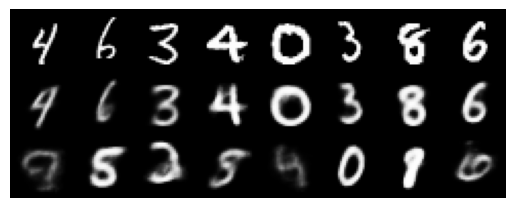

====> Epoch: 9 Average test loss: 117.200722


In [457]:
# Define training variables, feel free to modify these for the problem
log_interval = 100
num_epochs = 10
image, cls = train_dataset[0]
input_dim = np.product(image.shape)
batch_size = 100
num_examples = len(train_dataset)
device = "cuda" if torch.cuda.is_available() else "cpu"

latent_dim = 6
hidden_dims = [32, 128, 512]

all_losses = {
  f"vae{dim}": {"train_losses": [], "test_losses": []} 
  for dim in hidden_dims}
models = {}
buffers = {}

# debug = True
debug = False
if debug:
  hidden_dims = [32, 128, 512]
  num_epochs = 2



for hidden_dim in hidden_dims:
  # build model and buffer
  vae = VAE(
    input_dim=input_dim,
    hidden_dim=hidden_dim,
    latent_dim=latent_dim,
    device=device
  )
  buffer = Buffer(size=5000)
  
  # put model on device
  if torch.cuda.is_available():
    vae.cuda()

  # device optimizer
  vae_optimizer = optim.Adam(vae.parameters())

  ######### Your code starts here #########
  # Define the loss function for a Variational Autoencoder.
  def vae_loss_fn(recon_x, x, mu, log_var):
    """
    recon_x: (batch_size, 1, 28, 28)
    x: (batch_size, 1, 28, 28)
    mu: (batch_size, latent_dim)
    log_var: (batch_size, latent_dim)
    """
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + log_var - mu **2 - log_var.exp())
    return recon_loss + kl_loss
  ######### Your code ends here #########

  for epoch in range(0, num_epochs):
    avg_train_loss_epoch = train_single_epoch(
      model_cls="vae",
      model=vae,
      loss_fn=vae_loss_fn,
      data_loader=train_loader,
      optimizer=vae_optimizer,
      epoch=epoch
    )

    avg_test_loss_epoch = test_single_epoch(
      model_cls="vae",
      model=vae,
      loss_fn=vae_loss_fn,
      data_loader=test_loader,
      epoch=epoch,
      buffer=buffer
    )

    all_losses[f"vae{hidden_dim}"]["train_losses"].append(avg_train_loss_epoch)
    all_losses[f"vae{hidden_dim}"]["test_losses"].append(avg_test_loss_epoch)
  models[f"vae{hidden_dim}"] = vae
  buffers[f"vae{hidden_dim}"] = buffer

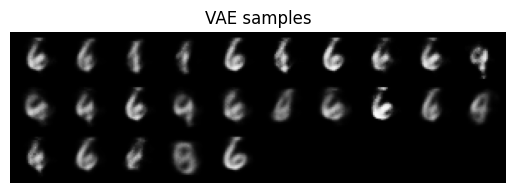

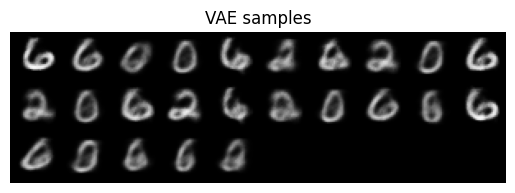

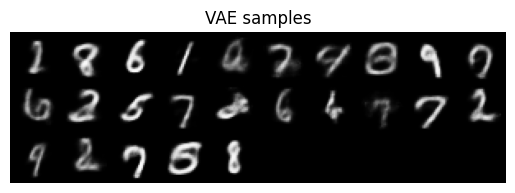

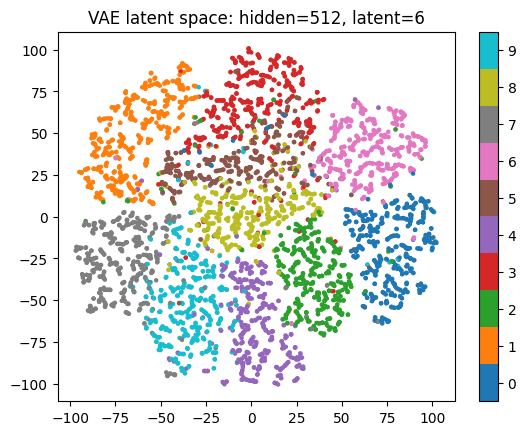

<Figure size 640x480 with 0 Axes>

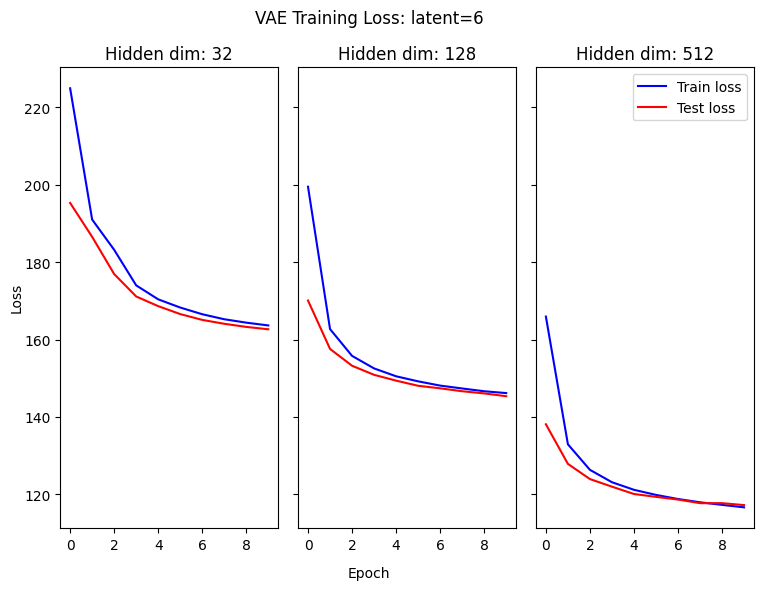

In [458]:
for model_key in ["vae32", "vae128", "vae512"]:
  model = models[model_key]
  buffer = buffers[model_key]
  
  plt.clf()

  title = f"VAE samples: hidden={model.hidden_dim}, latent={model.latent_dim}"
  viz_samples_vae(model, model_key, "VAE samples")

  title = f"VAE latent space: hidden={model.hidden_dim}, latent={model.latent_dim}"
  viz_tsne(buffer, model_key, title)

plot_losses(all_losses, "vae", hidden_dims, f"VAE Training Loss: latent={model.latent_dim}", "vae_losses")


# Bonus task: Conditional VAE

In [437]:
class ConditionalVAE(nn.Module):

  def __init__(
      self,
      input_dim: int,
      hidden_dim: int = 256,
      latent_dim: int= 2,
      embedding_dim: int = 64,
      num_classes: int = 10,
      device: str = "cuda"
  ):
    super(ConditionalVAE, self).__init__()

    self.latent = None
    self.latent_dim = latent_dim
    self.hidden_dim = hidden_dim
    self.device = device

    ######### Your code starts here #########
    # Encoder architecture:
    # 2 fully connected layers with ReLU activations

    # Decoder architecture:
    # 3 fully connected layers with ReLU activations

    # Separate linear layers to predict the latent mean and logvar

    # Use an embedding layer to encode the class label.
    # See https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html.

    # Choose the correct final layer output activation

    self.label_embed = nn.Embedding(num_classes, embedding_dim)

    self.encoder = nn.Sequential(
      nn.Flatten(),
      nn.Linear(input_dim + embedding_dim, hidden_dim),
      nn.ReLU(inplace=True),
      Split(
        nn.Linear(hidden_dim, latent_dim), # mean layer
        nn.Linear(hidden_dim, latent_dim), # logvar layer
      )
    )

    self.decoder = nn.Sequential(
      nn.Linear(latent_dim + embedding_dim, hidden_dim),
      nn.ReLU(inplace=True),
      nn.Linear(hidden_dim, hidden_dim),
      nn.ReLU(inplace=True),
      nn.Linear(hidden_dim, input_dim),
      nn.Sigmoid(), # to get pixel values between 0 and 1
      nn.Unflatten(1, (1, 28, 28))
    )

    ######### Your code ends here #########

  def reparameterize(self, mu, log_var):
    std = torch.exp(0.5 * log_var)
    eps = torch.randn_like(std)
    return eps.mul(std).add_(mu)  # return z sample

  def sample(self, n, class_label=0):
    sample = torch.randn(n, self.latent_dim).to(self.device)
    class_label = torch.tensor(class_label).repeat(n).to(self.device)
    return self.decode(sample, class_label)

  def decode(self, x, class_label):
    # embed the class label
    label_embed = self.label_embed(class_label)
    decoder_input = torch.cat([x, label_embed], dim=-1)
    z = self.decoder(decoder_input)
    return z

  def encode(self, x, class_label):
    # embed the class label
    label_embed = self.label_embed(class_label)

    encoder_input = torch.cat([x.view(x.shape[0], -1), label_embed], dim=-1)
    mu, log_var = self.encoder(encoder_input)

    return mu, log_var

  def forward(self, x, class_label):
    mu, log_var = self.encode(x, class_label)
    z = self.reparameterize(mu, log_var)
    self.latent = z
    return self.decode(z, class_label), mu, log_var

# Bonus task: Train CVAE

====> Epoch: 0 Average loss: 200.900405
Reconstructions: 


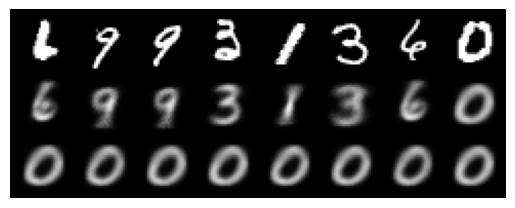

====> Epoch: 0 Average test loss: 166.074367
====> Epoch: 1 Average loss: 160.831516
Reconstructions: 


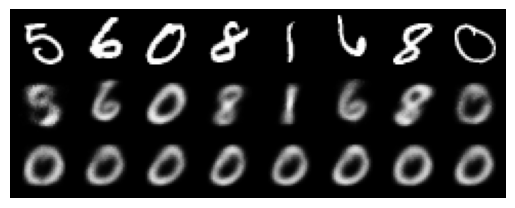

====> Epoch: 1 Average test loss: 154.281844
====> Epoch: 2 Average loss: 151.437064
Reconstructions: 


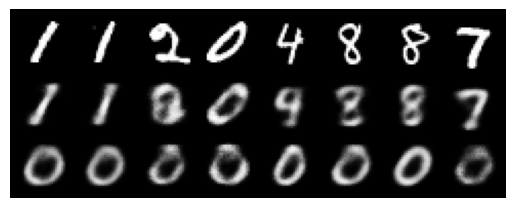

====> Epoch: 2 Average test loss: 147.285998
====> Epoch: 3 Average loss: 146.146121
Reconstructions: 


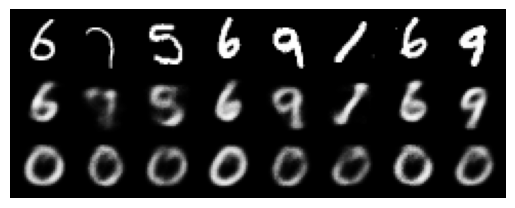

====> Epoch: 3 Average test loss: 143.461310
====> Epoch: 4 Average loss: 141.737356
Reconstructions: 


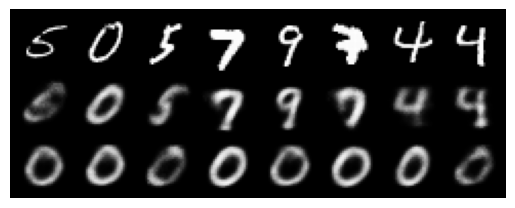

====> Epoch: 4 Average test loss: 139.027203
====> Epoch: 5 Average loss: 138.648584
Reconstructions: 


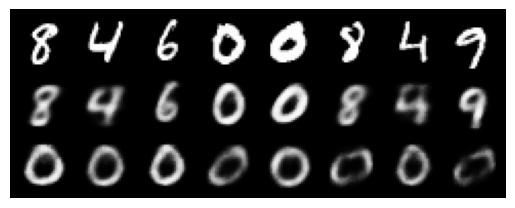

====> Epoch: 5 Average test loss: 136.653210
====> Epoch: 6 Average loss: 136.726880
Reconstructions: 


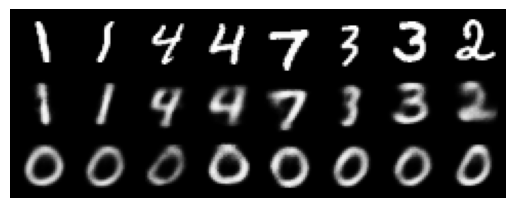

====> Epoch: 6 Average test loss: 134.783960
====> Epoch: 7 Average loss: 135.221693
Reconstructions: 


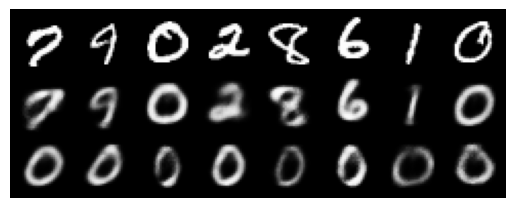

====> Epoch: 7 Average test loss: 133.529262
====> Epoch: 8 Average loss: 134.028615
Reconstructions: 


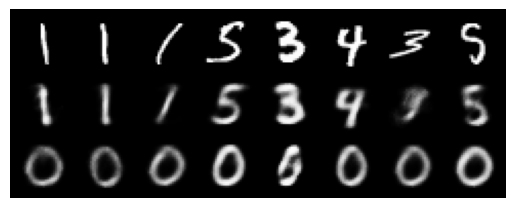

====> Epoch: 8 Average test loss: 132.529217
====> Epoch: 9 Average loss: 133.118361
Reconstructions: 


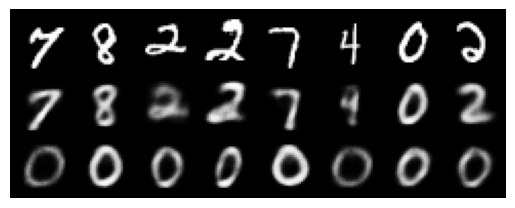

====> Epoch: 9 Average test loss: 131.833194
====> Epoch: 0 Average loss: 179.498503
Reconstructions: 


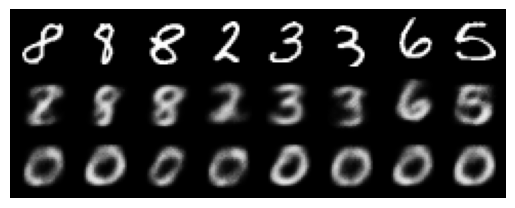

====> Epoch: 0 Average test loss: 153.443385
====> Epoch: 1 Average loss: 140.411892
Reconstructions: 


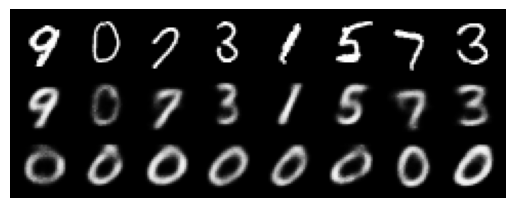

====> Epoch: 1 Average test loss: 131.878128
====> Epoch: 2 Average loss: 129.311826
Reconstructions: 


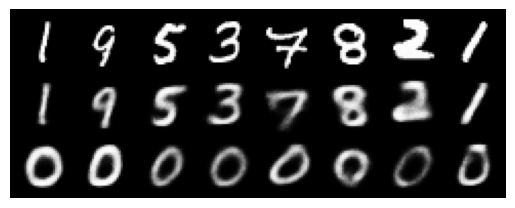

====> Epoch: 2 Average test loss: 125.558703
====> Epoch: 3 Average loss: 124.105470
Reconstructions: 


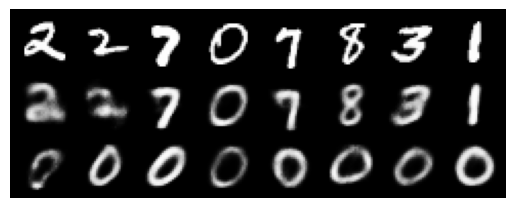

====> Epoch: 3 Average test loss: 121.279363
====> Epoch: 4 Average loss: 120.891196
Reconstructions: 


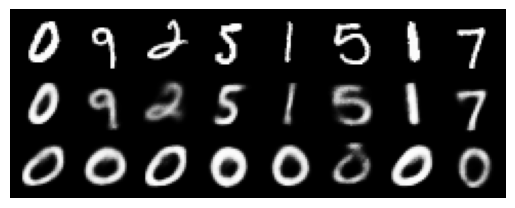

====> Epoch: 4 Average test loss: 118.566491
====> Epoch: 5 Average loss: 118.818706
Reconstructions: 


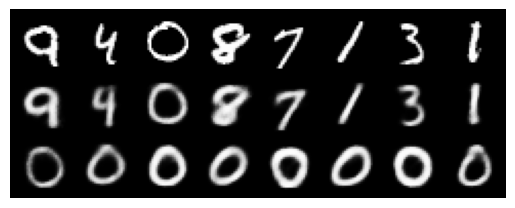

====> Epoch: 5 Average test loss: 116.936164
====> Epoch: 6 Average loss: 117.297228
Reconstructions: 


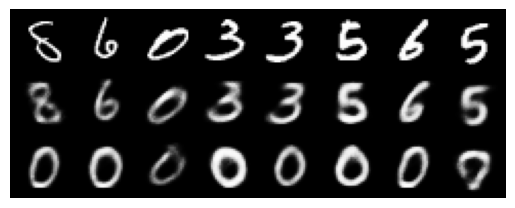

====> Epoch: 6 Average test loss: 115.849997
====> Epoch: 7 Average loss: 116.166677
Reconstructions: 


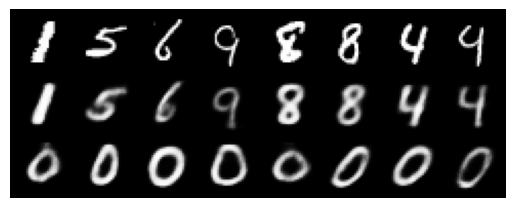

====> Epoch: 7 Average test loss: 114.924134
====> Epoch: 8 Average loss: 115.317094
Reconstructions: 


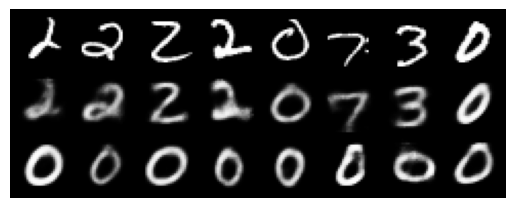

====> Epoch: 8 Average test loss: 114.190709
====> Epoch: 9 Average loss: 114.550552
Reconstructions: 


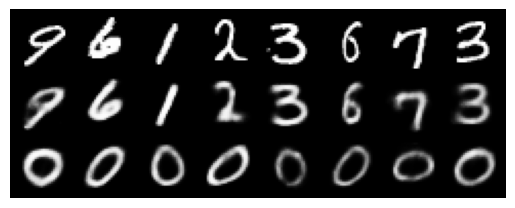

====> Epoch: 9 Average test loss: 113.655268
====> Epoch: 0 Average loss: 154.233929
Reconstructions: 


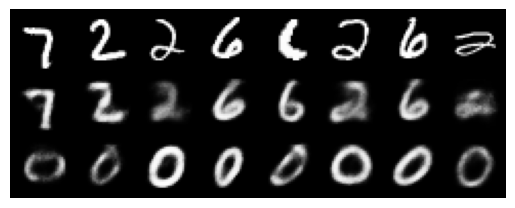

====> Epoch: 0 Average test loss: 125.585422
====> Epoch: 1 Average loss: 121.123537
Reconstructions: 


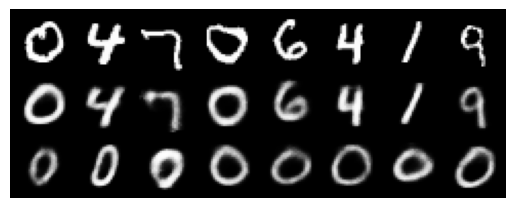

====> Epoch: 1 Average test loss: 116.580738
====> Epoch: 2 Average loss: 115.537976
Reconstructions: 


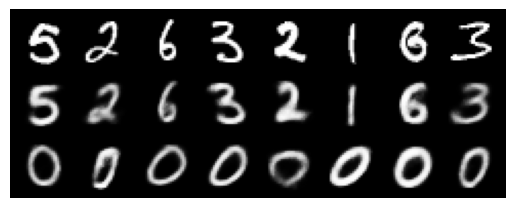

====> Epoch: 2 Average test loss: 113.020911
====> Epoch: 3 Average loss: 112.713526
Reconstructions: 


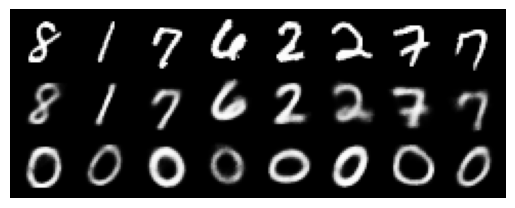

====> Epoch: 3 Average test loss: 110.871414
====> Epoch: 4 Average loss: 110.855335
Reconstructions: 


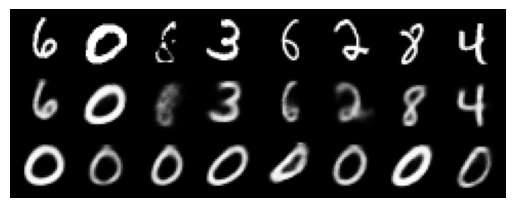

====> Epoch: 4 Average test loss: 109.488128
====> Epoch: 5 Average loss: 109.469032
Reconstructions: 


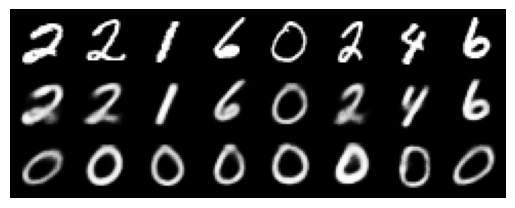

====> Epoch: 5 Average test loss: 108.545348
====> Epoch: 6 Average loss: 108.460428
Reconstructions: 


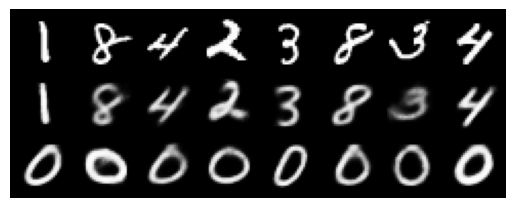

====> Epoch: 6 Average test loss: 107.872170
====> Epoch: 7 Average loss: 107.588355
Reconstructions: 


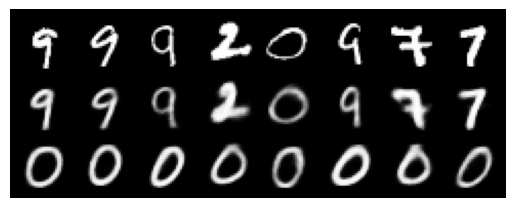

====> Epoch: 7 Average test loss: 107.376728
====> Epoch: 8 Average loss: 106.900415
Reconstructions: 


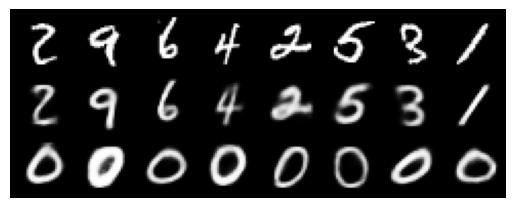

====> Epoch: 8 Average test loss: 107.069375
====> Epoch: 9 Average loss: 106.319941
Reconstructions: 


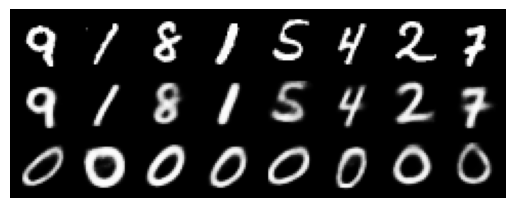

====> Epoch: 9 Average test loss: 106.432145


In [455]:
# Define training variables, feel free to modify these for the problem
log_interval = 100
num_epochs = 10
image, cls = train_dataset[0]
input_dim = np.product(image.shape)
batch_size = 100
num_examples = len(train_dataset)
device = "cuda" if torch.cuda.is_available() else "cpu"

latent_dim = 6
hidden_dims = [32, 128, 512]

all_losses = {
  f"cvae{dim}": {"train_losses": [], "test_losses": []} 
  for dim in hidden_dims}
models = {}
buffers = {}

# debug = True
debug = False
if debug:
  hidden_dims = [32, 128, 512]
  num_epochs = 2

for hidden_dim in hidden_dims:
  # build model and buffer
  cvae = ConditionalVAE(
    input_dim=input_dim,
    hidden_dim=hidden_dim,
    latent_dim=latent_dim,
    num_classes=10,
    device=device
  )
  buffer = Buffer(size=5000)

  # put model on device
  if torch.cuda.is_available():
    cvae.cuda()

  # device optimizer
  cvae_optimizer = optim.Adam(cvae.parameters())

  for epoch in range(0, num_epochs):
    avg_train_loss_epoch = train_single_epoch(
      model_cls="cvae",
      model=cvae,
      loss_fn=vae_loss_fn,
      data_loader=train_loader,
      optimizer=cvae_optimizer,
      epoch=epoch
    )

    avg_test_loss_epoch = test_single_epoch(
      model_cls="cvae",
      model=cvae,
      loss_fn=vae_loss_fn,
      data_loader=test_loader,
      epoch=epoch,
      buffer=buffer
    )

    all_losses[f"cvae{hidden_dim}"]["train_losses"].append(avg_train_loss_epoch)
    all_losses[f"cvae{hidden_dim}"]["test_losses"].append(avg_test_loss_epoch)
  models[f"cvae{hidden_dim}"] = cvae
  buffers[f"cvae{hidden_dim}"] = buffer

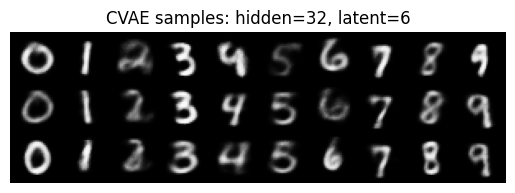

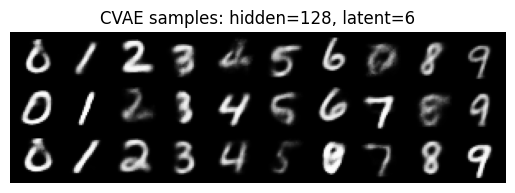

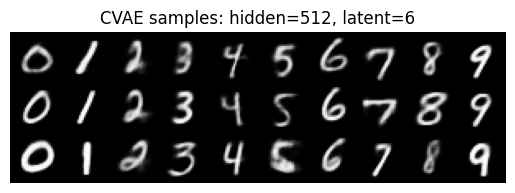

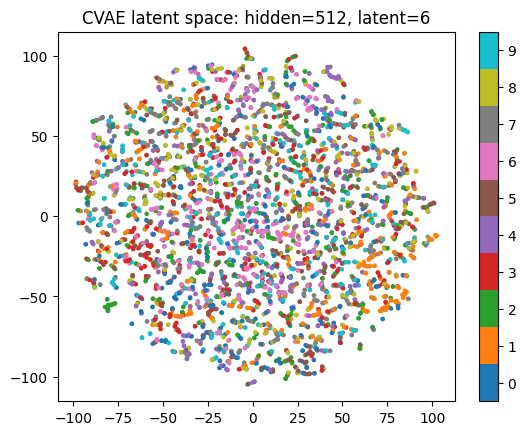

<Figure size 640x480 with 0 Axes>

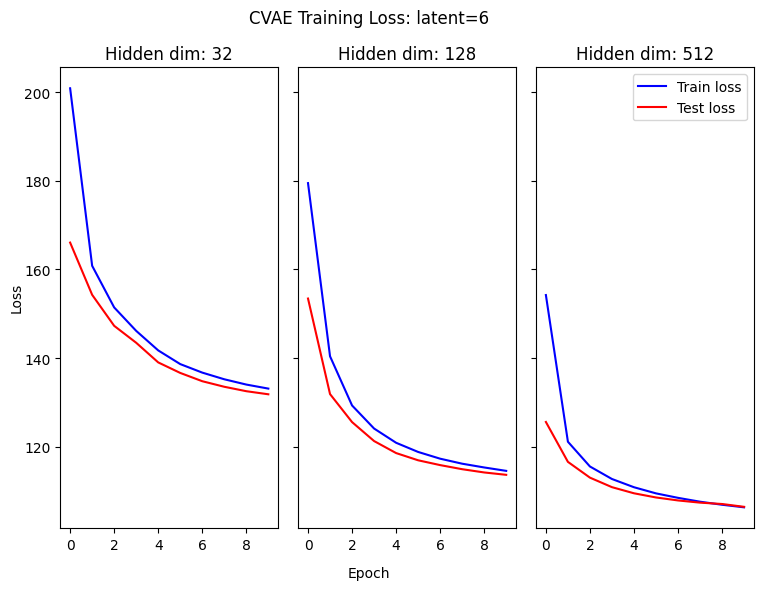

In [456]:
for model_key in ["cvae32", "cvae128", "cvae512"]:
  model = models[model_key]
  buffer = buffers[model_key]
  
  plt.clf()

  title = f"CVAE samples: hidden={model.hidden_dim}, latent={model.latent_dim}"
  viz_samples_cvae(model, model_key, title)

  title = f"CVAE latent space: hidden={model.hidden_dim}, latent={model.latent_dim}"
  viz_tsne(buffer, model_key, title)

plot_losses(all_losses, "cvae", hidden_dims, f"CVAE Training Loss: latent={model.latent_dim}", "cvae_losses")